## Group Project notebook by Group 12

* Topic: Determining asked Price of used cars in US (advertised on Truecar.com in 2018) using predictor variables
* ML models used: Linear regression, Decision Tree, Random forest

* The code has 10 sections:
* Part A) Reading in data, checking dataframe shape, format of columns and unique number of entries by each column
* Part B) Data Munging/Cleaning
* Part C) Checking distribution of data
* Part D) Exploratory data analysis - graphs
* Part E): Feature Engineering work
* PART F): Preparing data for modeling
* Part G): Pipeline for Training and Testing dataset
* Part H): Develop, Train and Test Model using Scikit-Learn
* Part H.a): Linear Regression
* Part H.b): Decision Tree Regressor
* Part H.c): Random Forest Regressor
* Part I): Execute Random Forest using Spark ML and perform Grid search
* Part J): Comparison between the different models and Conclusion 


## Group members:
* Gurunath Gandikota (1916016)
* Swaminath Gowrishankar (1916018)
* Shekhar Kanodia (1916026)
* Pusparghya Pakrasi (1916043)

In [2]:
# Import libraries

from pyspark.sql import SQLContext
import matplotlib
import matplotlib.pyplot as plt
from pyspark.sql import Row
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import *
import atexit
from numpy import array
import numpy as np
import pandas as pd
import datetime

In [3]:
# Print all outputs in a block - not just the last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
import pyspark

from pyspark import SparkContext
from pyspark.sql.session import SparkSession

In [5]:
sc = SparkContext('local')
spark = SparkSession(sc)

## (Part A) Reading in data, checking dataframe shape, format of columns and unique number of entries by each column

In [155]:
#Importing data hosted on AWS location

#(1) Used car dataset:
url="https://aws-logs-460894893345-us-east-1.s3.amazonaws.com/tc20171021.csv"
from pyspark import SparkFiles
spark.sparkContext.addFile(url)
usedcar_data_trans = spark.read.csv(SparkFiles.get("tc20171021.csv"), header=True, inferSchema=True)

#(2) US State wise Median income dataset from US Labor website:
url1="https://aws-logs-460894893345-us-east-1.s3.amazonaws.com/Median_inc_2018.csv"
from pyspark import SparkFiles
spark.sparkContext.addFile(url1)
median_income = spark.read.csv(SparkFiles.get("Median_inc_2018.csv"), header=True, inferSchema=True)

In [7]:
usedcar_data_trans.show(6)

+---+-----+----+-------+--------------+-----+-----------------+-----+-----------------+
| Id|Price|Year|Mileage|          City|State|              Vin| Make|            Model|
+---+-----+----+-------+--------------+-----+-----------------+-----+-----------------+
|  1|16472|2015|  18681|Jefferson City|   MO|KL4CJBSBXFB267643|Buick|EncoreConvenience|
|  2|15749|2015|  27592|      Highland|   IN|KL4CJASB5FB245057|Buick|        EncoreFWD|
|  3|16998|2015|  13650|         Boone|   NC|KL4CJCSB0FB264921|Buick|    EncoreLeather|
|  4|15777|2015|  25195|   New Orleans|   LA|KL4CJASB4FB217542|Buick|        EncoreFWD|
|  5|16784|2015|  22800|     Las Vegas|   NV|KL4CJBSB3FB166881|Buick|EncoreConvenience|
|  6|17020|2016|  16877|  Grand Island|   NY|KL4CJASB7GB536760|Buick|        EncoreFWD|
+---+-----+----+-------+--------------+-----+-----------------+-----+-----------------+
only showing top 6 rows



In [7]:
usedcar_data_trans.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- Price: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Mileage: integer (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Vin: string (nullable = true)
 |-- Make: string (nullable = true)
 |-- Model: string (nullable = true)



In [8]:
#Printing number of rows and columns
print("Number of rows:"+"{:,}".format(usedcar_data_trans.count()), "Number of columns:",len(usedcar_data_trans.columns))

Number of rows:1,233,042 Number of columns: 9


In [8]:
#Data type format of the columns in dataset
usedcar_data_trans.dtypes

[('Id', 'int'),
 ('Price', 'int'),
 ('Year', 'int'),
 ('Mileage', 'int'),
 ('City', 'string'),
 ('State', 'string'),
 ('Vin', 'string'),
 ('Make', 'string'),
 ('Model', 'string')]

In [9]:
#Describing the dataset
usedcar_data_trans.describe('Price','Mileage','Year').show()

+-------+------------------+-----------------+------------------+
|summary|             Price|          Mileage|              Year|
+-------+------------------+-----------------+------------------+
|  count|           1233042|          1233042|           1233042|
|   mean|21084.749881999152|52771.75223309506|2013.3251008481463|
| stddev|13142.316183328494|81434.85511629721| 3.423717133938921|
|    min|              1500|                5|              1997|
|    max|            499500|         77587763|              2018|
+-------+------------------+-----------------+------------------+



In [14]:
#Distrinct number of Car Make entities in our data
usedcar_data_trans.select('Make').distinct().count()

58

In [15]:
#Distrinct number of Car Model entities in our data
usedcar_data_trans.select('Model').distinct().count()

3110

In [16]:
#Distrinct number of US States in our data
usedcar_data_trans.select('State').distinct().count()

59

There are 59 distinct US states which seems data anomaly. there should be 51 including Washington D.C.

## (Part B) Data Munging/Cleaning

### B.1: Fixing US state column

In [17]:
usedcar_data_trans.select('State').distinct().sort('State').show(59)

+-----+
|State|
+-----+
|   AK|
|   AL|
|   AR|
|   AZ|
|   Az|
|   CA|
|   CO|
|   CT|
|   Ca|
|   DC|
|   DE|
|   FL|
|   Fl|
|   GA|
|   Ga|
|   HI|
|   IA|
|   ID|
|   IL|
|   IN|
|   KS|
|   KY|
|   LA|
|   MA|
|   MD|
|   ME|
|   MI|
|   MN|
|   MO|
|   MS|
|   MT|
|   Md|
|   NC|
|   ND|
|   NE|
|   NH|
|   NJ|
|   NM|
|   NV|
|   NY|
|   OH|
|   OK|
|   OR|
|   Oh|
|   PA|
|   RI|
|   SC|
|   SD|
|   TN|
|   TX|
|   UT|
|   VA|
|   VT|
|   Va|
|   WA|
|   WI|
|   WV|
|   WY|
|   ga|
+-----+



There are discrepancies such as FL and Fl; CA and Ca; GA, Ga, ga; MD and Md, VA and Va, OH and Oh; AZ and Az etc. These need to be rectified

Fl -> FL
Ca -> CA
Ga, ga -> GA
Md -> MD
Va -> VA
Oh -> OH
Az -> AZ

In [8]:
#Converting to uppercase
from pyspark.sql import functions as f

usedcar_data_trans = usedcar_data_trans.withColumn(
                    "New_state",
                    f.upper(f.col("State")))

In [7]:
usedcar_data_trans.select('New_state').distinct().count()

51

### The text issue with states is fixed, there are 51 distinct entries now

## (Part C) Checking distribution of data

In [12]:
usedcar_data_trans.groupBy("Year").agg({'Id':'count','Price': 'mean','Mileage': 'mean'}).sort("count(ID)",ascending=False).show()

+----+------------------+------------------+---------+
|Year|        avg(Price)|      avg(Mileage)|count(Id)|
+----+------------------+------------------+---------+
|2015|24615.905655765964| 34656.79936193149|   229129|
|2014| 21703.80348812269| 43089.46589182619|   223788|
|2016|24932.604984675283|26357.137425447316|   193152|
|2017|  28778.8686778498|16424.106349920556|   142238|
|2013|18816.130736808507| 61551.20742159265|   106527|
|2012|  17054.4381062451| 74453.66020005228|    72681|
|2011|16071.988533831305| 84790.37079181138|    57299|
|2010|14043.746532937097| 91808.72161961367|    40380|
|2008|12460.298379597012|108415.34056643653|    35485|
|2007|11406.312046922367|115839.88753789377|    30348|
|2009|12758.257511822481| 98966.13470352856|    27490|
|2006|10385.330745630346|  120986.335626627|    21512|
|2005| 9422.703347465671|126704.39530468898|    15803|
|2004| 8751.952689620339| 131166.0053876589|    11879|
|2003| 8126.114951071473|134031.12089681654|     8073|
|2002| 793

In [21]:
usedcar_data_trans.groupBy("New_state").agg({'Id':'count','Price': 'mean','Mileage': 'mean'}).sort("count(ID)",ascending=False).show(51)

+---------+------------------+------------------+---------+
|New_state|        avg(Price)|      avg(Mileage)|count(Id)|
+---------+------------------+------------------+---------+
|       TX|23205.636322588383| 51571.83236325411|   141741|
|       CA|21234.500565742765| 48262.45188595317|   115777|
|       FL| 20719.37049364731| 46260.66043076583|   108458|
|       GA| 21100.48434060081| 56016.99188622967|    56324|
|       IL|20827.914986790198|   51977.986573052|    55262|
|       NC|21095.673322459083| 56478.09816825093|    53337|
|       VA| 18741.56700864693| 61228.31052345152|    49613|
|       PA|21130.626240352813|48807.757491118464|    40815|
|       NJ| 21228.44627070749| 50329.00552199725|    38573|
|       NY|22042.091490138788|45039.849890430974|    38332|
|       OH| 18464.37292085409| 57420.75449328556|    34329|
|       WA| 21488.29743543759| 58175.70032281205|    33456|
|       CO|20995.879213398683|63689.869952190515|    33257|
|       AZ|19912.956773202397|54220.8690

In [22]:
usedcar_data_trans.groupBy("New_state").agg({'Id':'count','Price': 'mean','Mileage': 'mean'}).sort("avg(Price)",ascending=False).show(51)

+---------+------------------+------------------+---------+
|New_state|        avg(Price)|      avg(Mileage)|count(Id)|
+---------+------------------+------------------+---------+
|       WY|24548.950396825396| 60667.08432539683|     1008|
|       MT|24417.711771177117|63210.898789878986|     2727|
|       SD| 24051.72218917311|  67305.9506246282|     1681|
|       MS|23365.633679354094| 56229.39953863899|     8670|
|       TX|23205.636322588383| 51571.83236325411|   141741|
|       AR|22959.521537510303| 50402.12819455894|     9704|
|       WV|22921.719167904903|44381.878157503714|     2019|
|       LA|22651.757421908613| 50592.35151880217|    11621|
|       NM| 22646.34179879332| 49694.06342079416|     7127|
|       ME|22123.733511246664|49177.269157453295|     2623|
|       NY|22042.091490138788|45039.849890430974|    38332|
|       RI|21984.852080123266| 42267.42835130971|     2596|
|       AL|21881.348071595992| 56793.06376518219|    18772|
|       NE|21802.892411143133|   63083.4

#### Most the used cars listings are from Texas, followed by California and then Florida. In terms of average price asked, Texas comes 5th, Californi and Florida are way below

In [23]:
#Used cars listed by Make of the car: sorted by Count of listings
usedcar_data_trans.groupBy("Make").agg({'Id':'count','Price': 'mean','Mileage': 'mean'}).sort("count(ID)",ascending=False).show()

+-------------+------------------+------------------+---------+
|         Make|        avg(Price)|      avg(Mileage)|count(Id)|
+-------------+------------------+------------------+---------+
|         Ford|21311.796720967413| 57283.25005709912|   161999|
|    Chevrolet| 21770.09218486166|  54561.4084466781|   150426|
|       Toyota|19382.693094715803| 56534.49138215789|   118069|
|       Nissan|16620.979029480295| 46231.91215682302|    98710|
|        Honda|16670.602575442248|57588.277211238295|    76880|
|         Jeep|22286.489746862724| 48777.57921522471|    60323|
|      Hyundai|14298.765531502188|47737.850531593685|    54647|
|        Dodge|18022.711726641413| 60832.63630445076|    50688|
|          GMC|28162.684887908003| 59596.93711232431|    43045|
|          Kia|15388.701055236494| 43430.19764672923|    42834|
|Mercedes-Benz| 31696.05024782985| 48761.24114237759|    38131|
|   Volkswagen|14625.569258535119| 44565.94811249812|    33245|
|          BMW|26920.712663890175| 47738

In [24]:
#Used cars listed by Make of the car: sorted by Count of Avg. Price
usedcar_data_trans.groupBy("Make").agg({'Id':'count','Price': 'mean','Mileage': 'mean'}).sort("avg(Price)",ascending=False).show()

+-------------+------------------+------------------+---------+
|         Make|        avg(Price)|      avg(Mileage)|count(Id)|
+-------------+------------------+------------------+---------+
|      McLaren|     215340.859375|       4498.296875|       64|
|  Rolls-Royce|201293.83333333334| 17051.01851851852|      108|
|      Ferrari|200600.08571428573| 9715.707142857143|      420|
|  Lamborghini| 186711.3829787234|13835.390070921985|      141|
|      Bentley|  101075.310626703|27516.634877384196|      367|
|        Aston| 99573.61744966442|17539.765100671142|      149|
|      Maybach| 86702.36363636363| 44603.36363636364|       11|
|        Tesla|62328.514204545456|28184.488636363636|      352|
|           AM| 59934.21052631579|  67332.8947368421|       19|
|      Porsche| 57277.45998271392| 38241.06378565255|     5785|
|         Alfa|54228.704545454544| 3877.159090909091|       44|
|        Lotus|52548.755102040814|16237.714285714286|       49|
|     Maserati| 49909.68455402466| 23971

In [25]:
#Used cars listed by Make & Model of the car: sorted by avg. Price
usedcar_data_trans.groupBy("Make","Model").agg({'Id':'count','Price': 'mean','Mileage': 'mean'}).sort("avg(Price)",ascending=False).show()

+-------------+--------------------+------------------+------------------+---------+
|         Make|               Model|        avg(Price)|      avg(Mileage)|count(Id)|
+-------------+--------------------+------------------+------------------+---------+
|        Lexus|              LFALFA|          458988.0|             231.0|        1|
|        Lexus|              LFA2dr|          419999.0|             600.0|        1|
|      McLaren|            675LT2dr|        403100.375|           600.125|        8|
|  Lamborghini|AventadorConvertible|          354737.8|            8566.6|        5|
|      Ferrari|      GTC4LussoCoupe|          353851.2|            1528.0|        5|
|  Lamborghini|      AventadorCoupe| 351614.6666666667|            3252.5|        6|
|      Ferrari|                 488| 344013.0930232558|            1624.0|       43|
|  Rolls-Royce|     DawnConvertible|          327240.0|            2369.0|        3|
|      Ferrari|    F12berlinetta2dr| 326791.6666666667|2042.66666

In [26]:
#Used cars listed by Make & Model of the car: sorted by count of listings
usedcar_data_trans.groupBy("Make","Model").agg({'Id':'count','Price': 'mean','Mileage': 'mean'}).sort("count(ID)",ascending=False).show()

+----------+----------+------------------+------------------+---------+
|      Make|     Model|        avg(Price)|      avg(Mileage)|count(Id)|
+----------+----------+------------------+------------------+---------+
| Chevrolet| Silverado|29063.131282136343| 61742.53516337701|    36174|
|    Nissan| Altima2.5|15491.067879220162| 33419.06419400856|    16824|
|       GMC|    Sierra| 31887.87171392144| 59232.37314067148|    16471|
|      Jeep|     Grand| 25097.60427940536| 55247.96672264726|    16077|
|     Honda|    Accord|15471.330054864178| 55261.15897230028|    14946|
|      Ford|  F-1504WD|29232.324059413404|62278.786699841665|    13263|
|     Honda|     Civic|13593.551612628713| 48588.44243043145|    11751|
|      Jeep|  Wrangler| 31693.99555783359|42580.694259354175|    11706|
|       BMW|         3|22529.947174557543|49775.267181744675|    11131|
|Volkswagen|     Jetta|12284.156282998943|46088.181050206396|    10417|
|   Hyundai|     Santa|17910.002096854718|49585.304842735895|   

In [9]:
make_model_dist=usedcar_data_trans.groupBy("Make","Model").agg({'Id':'count','Price': 'mean','Mileage': 'mean'}).sort("avg(Price)",ascending=False).toPandas()

make_model_dist

,Make,Model,avg(Price),avg(Mileage),count(Id)
0,Lexus,LFALFA,458988.000,231.000,1
1,Lexus,LFA2dr,419999.000,600.000,1
2,McLaren,675LT2dr,403100.375,600.125,8
3,Lamborghini,AventadorConvertible,354737.800,8566.600,5
4,Ferrari,GTC4LussoCoupe,353851.200,1528.000,5
...,...,...,...,...,...
3124,Mercury,Mariner,1987.000,117025.000,1
3125,Volkswagen,CabrioCONVERTIBLE,1950.000,166616.000,1
3126,GMC,Yukon1500,1891.500,212267.750,4
3127,Chrysler,VoyagerBase,1688.000,172490.000,1


In [9]:
import numpy as np
np.round(make_model_dist.describe([.01,.1,.2,.3,.4,.5,.6,.7,.75,.8,.85,.9,.95,.99]),0)

,avg(Price),avg(Mileage),count(Id)
count,3129.0,3129.0,3129.0
mean,25329.0,65942.0,394.0
std,35215.0,49806.0,1292.0
min,1500.0,5.0,1.0
1%,2661.0,1110.0,1.0
10%,5050.0,9839.0,1.0
20%,7801.0,22618.0,4.0
30%,10502.0,33692.0,9.0
40%,13503.0,42348.0,21.0
50%,16819.0,54236.0,43.0


In [10]:
#For creating Low, Med and High price make-model car variants
Price_60_quantile=make_model_dist["avg(Price)"].quantile(0.6)
Price_90_quantile=make_model_dist["avg(Price)"].quantile(0.9)

Price_60_quantile
Price_90_quantile

20636.97312876155

47087.52878237886

In [11]:
make_model_dist["Price_60_quintile"]=Price_60_quantile
make_model_dist["Price_90_quintile"]=Price_90_quantile
#make_model_dist["Price_Category"] = make_model_dist["Price_Category"].astype("category")
make_model_dist.dtypes

Make                  object
Model                 object
avg(Price)           float64
avg(Mileage)         float64
count(Id)              int64
Price_60_quintile    float64
Price_90_quintile    float64
dtype: object

In [10]:
make_model_dist.head()

,Make,Model,avg(Price),avg(Mileage),count(Id),Price_60_quintile,Price_90_quintile
0,Lexus,LFALFA,458988.000,231.000,1,20636.973129,47087.528782
1,Lexus,LFA2dr,419999.000,600.000,1,20636.973129,47087.528782
2,McLaren,675LT2dr,403100.375,600.125,8,20636.973129,47087.528782
3,Lamborghini,AventadorConvertible,354737.800,8566.600,5,20636.973129,47087.528782
4,Ferrari,GTC4LussoCoupe,353851.200,1528.000,5,20636.973129,47087.528782


In [12]:
make_model_dist = make_model_dist.rename(columns = {'avg(Price)':'Avg_Price', 
                            'avg(Mileage)':'Avg_Mileage',
                            'count(Id)':'Count'
                            }
                )
make_model_dist.head()

,Make,Model,Avg_Price,Avg_Mileage,Count,Price_60_quintile,Price_90_quintile
0,Lexus,LFALFA,458988.000,231.000,1,20636.973129,47087.528782
1,Lexus,LFA2dr,419999.000,600.000,1,20636.973129,47087.528782
2,McLaren,675LT2dr,403100.375,600.125,8,20636.973129,47087.528782
3,Lamborghini,AventadorConvertible,354737.800,8566.600,5,20636.973129,47087.528782
4,Ferrari,GTC4LussoCoupe,353851.200,1528.000,5,20636.973129,47087.528782


In [13]:
#Creating a categorical variable called Price category based on the 60 percentile and 90 percentile values
make_model_dist["Model_Category"]=""

for i in range(0,len(make_model_dist)):
    if(make_model_dist.Avg_Price[i] < make_model_dist.Price_60_quintile[i]):
        make_model_dist.Model_Category[i]="Economy"
    elif(make_model_dist.Avg_Price[i] < make_model_dist.Price_90_quintile[i]):
        make_model_dist.Model_Category[i]="Medium"
    elif(make_model_dist.Avg_Price[i] > make_model_dist.Price_90_quintile[i]):
        make_model_dist.Model_Category[i]="Premium"
    else:
        make_model_dist.Model_Category[i]="NA"

<ipython-input-13-1dc4c908cc2e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  make_model_dist.Model_Category[i]="Premium"
<ipython-input-13-1dc4c908cc2e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  make_model_dist.Model_Category[i]="Medium"
<ipython-input-13-1dc4c908cc2e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  make_model_dist.Model_Category[i]="Economy"


In [14]:
print("Min values (floor values) for the 3 buckets:")
make_model_dist.groupby('Model_Category')['Avg_Price'].min()

print("Max values (ceiling values) for the 3 buckets:")
make_model_dist.groupby('Model_Category')['Avg_Price'].max()

Min values (floor values) for the 3 buckets:


Model_Category
Economy     1500.000000
Medium     20640.832447
Premium    47110.384000
Name: Avg_Price, dtype: float64

Max values (ceiling values) for the 3 buckets:


Model_Category
Economy     20621.535857
Medium      47081.814978
Premium    458988.000000
Name: Avg_Price, dtype: float64

#### Based on the min and max value check above, we can see:
* Economy is between 1500 and 2061
* Medium is between 20640 and 47081
* Premium is above 47110

60 percentile value is USD 20,636 and 90 percentile value is USD 47,087

So the assignment of model category values is fine

In [15]:
make_model_dist.groupby('Model_Category')['Model'].count()

Model_Category
Economy    1877
Medium      939
Premium     313
Name: Model, dtype: int64

In [16]:
make_model_dist['Make_Model']=make_model_dist.Make.map(str) + '_' + make_model_dist.Model.map(str)
make_model_dist.head()

,Make,Model,Avg_Price,Avg_Mileage,Count,Price_60_quintile,Price_90_quintile,Model_Category,Make_Model
0,Lexus,LFALFA,458988.000,231.000,1,20636.973129,47087.528782,Premium,Lexus_LFALFA
1,Lexus,LFA2dr,419999.000,600.000,1,20636.973129,47087.528782,Premium,Lexus_LFA2dr
2,McLaren,675LT2dr,403100.375,600.125,8,20636.973129,47087.528782,Premium,McLaren_675LT2dr
3,Lamborghini,AventadorConvertible,354737.800,8566.600,5,20636.973129,47087.528782,Premium,Lamborghini_AventadorConvertible
4,Ferrari,GTC4LussoCoupe,353851.200,1528.000,5,20636.973129,47087.528782,Premium,Ferrari_GTC4LussoCoupe


In [68]:
#import pandas as pd

#make_model_dist.to_csv('output.csv', header=True)

## (Part D) Exploratory data analysis - graphs

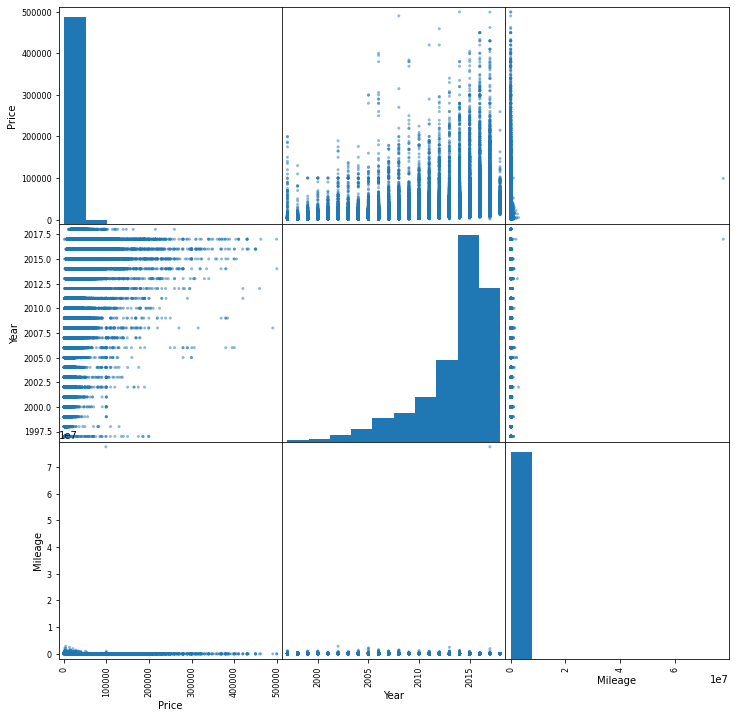

In [28]:
from pandas.plotting import scatter_matrix
numeric_data = usedcar_data_trans.select("Price", "Year", "Mileage").toPandas()
axs = scatter_matrix(numeric_data, figsize=(12, 12));

* The scatter plots show that older the car lower its price is
* The price, year ard mileage data are highly skewed. Some transformation (like log) needs to be applied to make the data look like normally distributed

In [15]:
r1 = usedcar_data_trans.toPandas().corr(method ='pearson') 
round(r1,2) 

,Id,Price,Year,Mileage,Year_Diff
Id,1.00,-0.01,0.04,-0.01,-0.04
Price,-0.01,1.00,0.41,-0.21,-0.41
Year,0.04,0.41,1.00,-0.39,-1.00
Mileage,-0.01,-0.21,-0.39,1.00,0.39
Year_Diff,-0.04,-0.41,-1.00,0.39,1.00


In [ ]:
from handyspark import *
hdf = usedcar_data_trans.toHandy()
fig, axs = plt.subplots(1, 3, figsize=(16, 3))
hdf.cols['Price'].hist(ax=axs[0])
hdf.cols['Year'].hist(ax=axs[1])
hdf.cols['Mileage'].hist(ax=axs[2])


In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(16, 3))
hdf.cols['Price'].boxplot(ax=axs[0])
hdf.cols['Year'].boxplot(ax=axs[1])
hdf.cols['Mileage'].boxplot(ax=axs[2])

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(16, 3))
hdf.cols[['Year','Price']].scatterplot(ax=axs[0])
hdf.cols[['Year','Mileage']].scatterplot(ax=axs[1])
hdf.cols[['Mileage','Price']].scatterplot(ax=axs[2])

There is a fairly good correlation between Price & Year and Year & Mileage as is generally expected.

In [56]:
year_dist=usedcar_data_trans.groupBy("Year").agg({'Id':'count','Price': 'mean','Mileage': 'mean'}).sort("Year",ascending=True).toPandas()

In [57]:
year_dist

,Year,avg(Price),avg(Mileage),count(Id)
0,1997,9381.464891,150685.203390,826
1,1998,6130.071963,146314.928972,1070
2,1999,6865.117974,146414.277685,1797
3,2000,6808.016667,141175.709783,2760
4,2001,7089.941270,139245.877226,3763
5,2002,7935.906728,135707.610323,5425
6,2003,8126.114951,134031.120897,8073
7,2004,8751.952690,131166.005388,11879
8,2005,9422.703347,126704.395305,15803
9,2006,10385.330746,120986.335627,21512


In [31]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

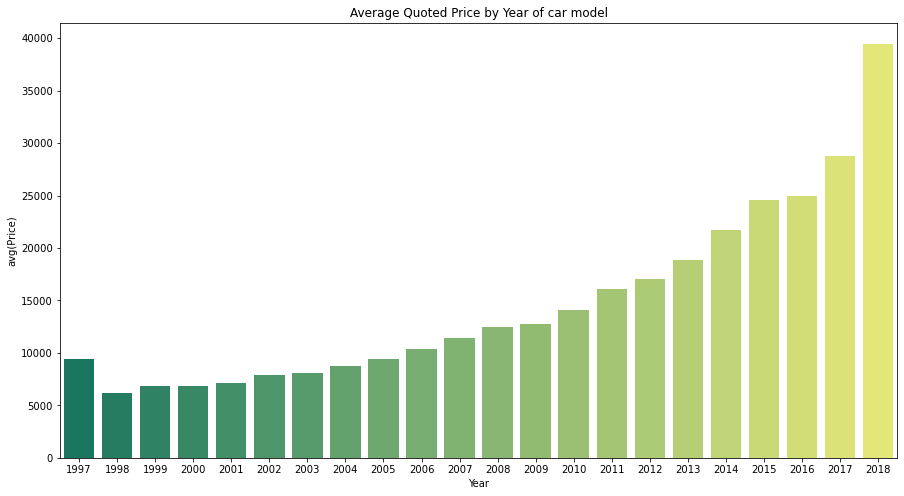

In [68]:
plt.figure(figsize=(15,8))

plt.title('Average Quoted Price by Year of car model')
sns.barplot(x='Year', y='avg(Price)', data=year_dist, palette='summer');

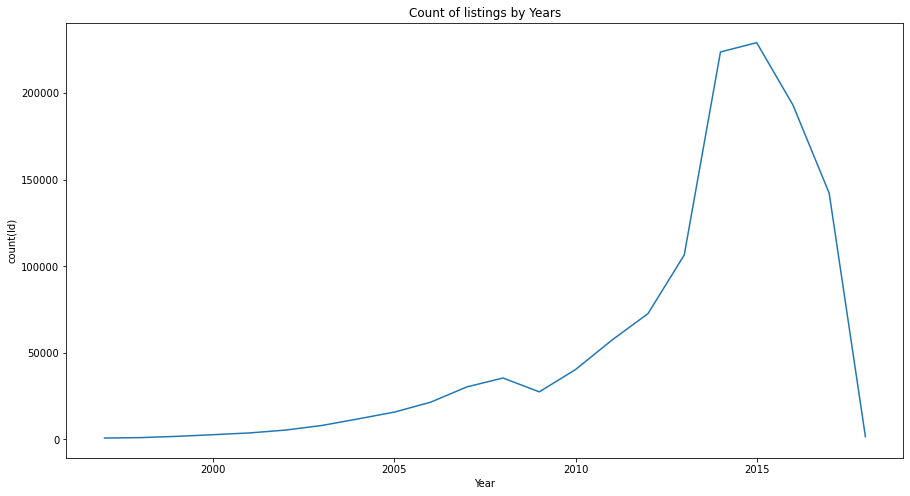

In [72]:
plt.figure(figsize=(15,8));
plt.title('Count of listings by Year of car model')
sns.lineplot(x='Year', y='count(Id)', data=year_dist);

In [76]:
make_dist=usedcar_data_trans.groupBy("Make").agg({'Id':'count','Price': 'mean','Mileage': 'mean'}).sort("count(ID)",ascending=False).toPandas()

make_dist


,Make,avg(Price),avg(Mileage),count(Id)
0,Ford,21311.796721,57283.250057,161999
1,Chevrolet,21770.092185,54561.408447,150426
2,Toyota,19382.693095,56534.491382,118069
3,Nissan,16620.979029,46231.912157,98710
4,Honda,16670.602575,57588.277211,76880
5,Jeep,22286.489747,48777.579215,60323
6,Hyundai,14298.765532,47737.850532,54647
7,Dodge,18022.711727,60832.636304,50688
8,GMC,28162.684888,59596.937112,43045
9,Kia,15388.701055,43430.197647,42834


In [ ]:
make_dist

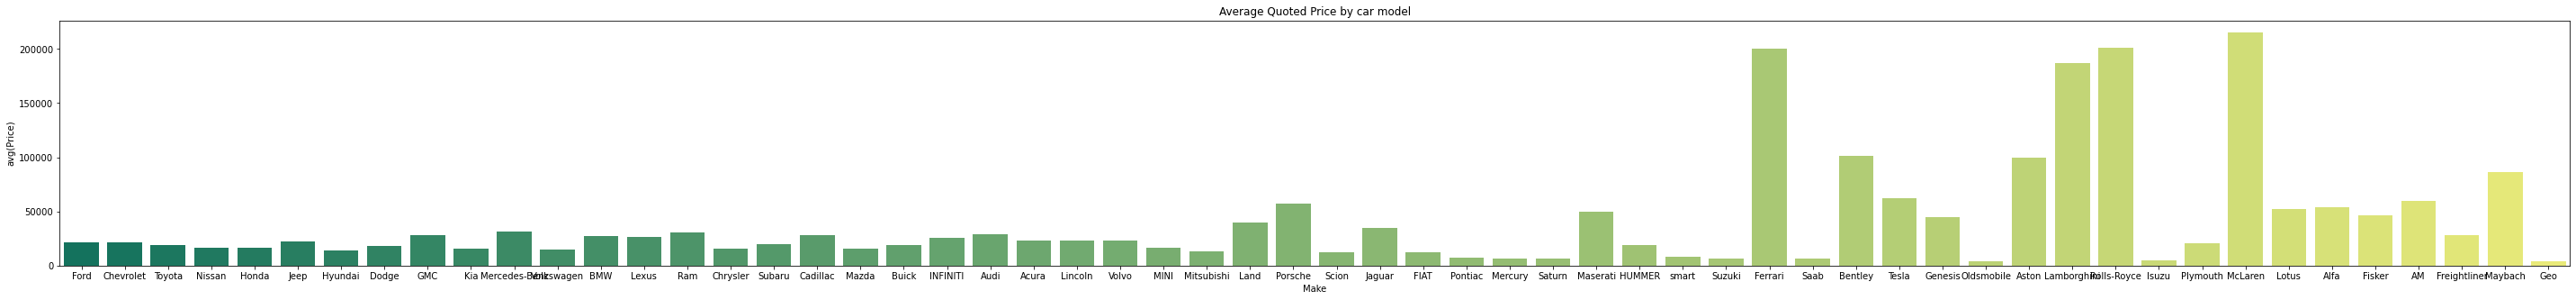

In [88]:
plt.figure(figsize=(50,5))

plt.title('Average Quoted Price by car model')
sns.barplot(x='Make', y='avg(Price)', data=make_dist, palette='summer');

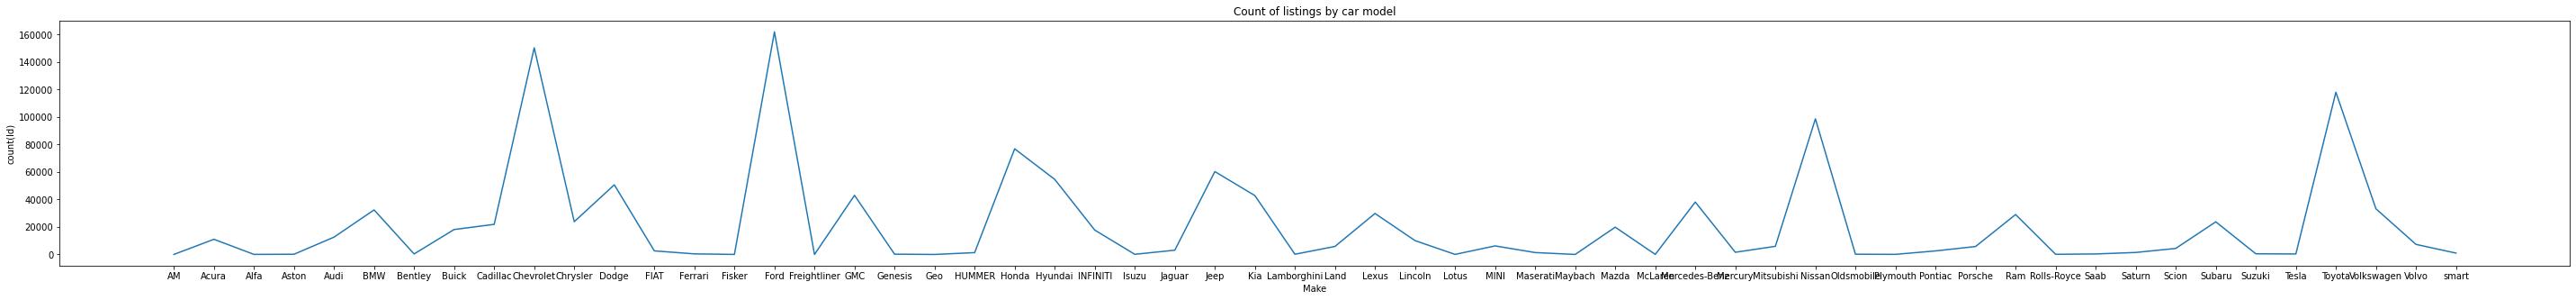

In [91]:
plt.figure(figsize=(50,5));
plt.title('Count of listings by car model')
sns.lineplot(x='Make', y='count(Id)', data=make_dist);

In [27]:
#carbox = usedcar_data_trans_df.boxplot(column = 'Price', by = 'Make', figsize = (80,30), layout = (10,1))

## (Part E): Feature Engineering work

#### (1) Creating Year_Diff column to calculate difference between current year and car model 

In [17]:
#Creating a new field called difference in years
from pyspark.sql import functions as f
from pyspark.sql.functions import current_date
from pyspark.sql.functions import year
from pyspark.sql.functions import to_date


usedcar_data_trans = usedcar_data_trans.withColumn(
                    "Year_Diff",
                    year(current_date()) - f.col("Year"))

In [16]:
usedcar_data_trans.show(10)

+---+-----+----+-------+--------------+-----+-----------------+-----+-----------------+---------+---------+
| Id|Price|Year|Mileage|          City|State|              Vin| Make|            Model|New_state|Year_Diff|
+---+-----+----+-------+--------------+-----+-----------------+-----+-----------------+---------+---------+
|  1|16472|2015|  18681|Jefferson City|   MO|KL4CJBSBXFB267643|Buick|EncoreConvenience|       MO|        5|
|  2|15749|2015|  27592|      Highland|   IN|KL4CJASB5FB245057|Buick|        EncoreFWD|       IN|        5|
|  3|16998|2015|  13650|         Boone|   NC|KL4CJCSB0FB264921|Buick|    EncoreLeather|       NC|        5|
|  4|15777|2015|  25195|   New Orleans|   LA|KL4CJASB4FB217542|Buick|        EncoreFWD|       LA|        5|
|  5|16784|2015|  22800|     Las Vegas|   NV|KL4CJBSB3FB166881|Buick|EncoreConvenience|       NV|        5|
|  6|17020|2016|  16877|  Grand Island|   NY|KL4CJASB7GB536760|Buick|        EncoreFWD|       NY|        4|
|  7|15950|2015|  27885|   W

In [17]:
#usedcar_data_trans.select("Year_Diff").describe()

usedcar_data_trans.describe('Year_Diff').show()

+-------+-----------------+
|summary|        Year_Diff|
+-------+-----------------+
|  count|          1233042|
|   mean|6.674899151853708|
| stddev|3.423717133939022|
|    min|                2|
|    max|               23|
+-------+-----------------+



#### (2) Bring a new column: State's median income from US Labour data into analysis dataset by merging on State column

##### (2.a) Trimming state column in used car dataset before merging

In [18]:
from pyspark.sql.functions import *

usedcar_data_trans = usedcar_data_trans.withColumn('New_state2',trim(usedcar_data_trans.New_state))

usedcar_data_trans.show(5)

+---+-----+----+-------+--------------+-----+-----------------+-----+-----------------+---------+---------+----------+
| Id|Price|Year|Mileage|          City|State|              Vin| Make|            Model|New_state|Year_Diff|New_state2|
+---+-----+----+-------+--------------+-----+-----------------+-----+-----------------+---------+---------+----------+
|  1|16472|2015|  18681|Jefferson City|   MO|KL4CJBSBXFB267643|Buick|EncoreConvenience|       MO|        5|        MO|
|  2|15749|2015|  27592|      Highland|   IN|KL4CJASB5FB245057|Buick|        EncoreFWD|       IN|        5|        IN|
|  3|16998|2015|  13650|         Boone|   NC|KL4CJCSB0FB264921|Buick|    EncoreLeather|       NC|        5|        NC|
|  4|15777|2015|  25195|   New Orleans|   LA|KL4CJASB4FB217542|Buick|        EncoreFWD|       LA|        5|        LA|
|  5|16784|2015|  22800|     Las Vegas|   NV|KL4CJBSB3FB166881|Buick|EncoreConvenience|       NV|        5|        NV|
+---+-----+----+-------+--------------+-----+---

In [19]:
usedcar_data_trans.select('New_state2').distinct().count()

51

##### (2.b) Reading median income dataset from US labor data adn creating data frame median_income

In [18]:
#median_income = (spark.read.csv('Median inc 2018_csv.csv',header=True, inferSchema=True))

In [19]:
median_income.show(6)

+---------+-------------+
|New_state|M_Income_2018|
+---------+-------------+
|       AL|        49936|
|       AK|        68734|
|       AZ|        62283|
|       AR|        49781|
|       CA|        70489|
|       CO|        73034|
+---------+-------------+
only showing top 6 rows



##### (2.c) Trimming state column in Median income dataset before merging

In [20]:
from pyspark.sql.functions import *

median_income = median_income.withColumn('New_state2',trim(median_income.New_state))

median_income.show(5)

+---------+-------------+----------+
|New_state|M_Income_2018|New_state2|
+---------+-------------+----------+
|       AL|        49936|        AL|
|       AK|        68734|        AK|
|       AZ|        62283|        AZ|
|       AR|        49781|        AR|
|       CA|        70489|        CA|
+---------+-------------+----------+
only showing top 5 rows



##### (2.d) Dropping New_state column from median income dataset

In [21]:
median_income=median_income.drop('New_state')

In [22]:
median_income.show(5)

+-------------+----------+
|M_Income_2018|New_state2|
+-------------+----------+
|        49936|        AL|
|        68734|        AK|
|        62283|        AZ|
|        49781|        AR|
|        70489|        CA|
+-------------+----------+
only showing top 5 rows



##### (2.e) Merge operation: Doing a left join (left being User car dataset) on New_state2 variable to bring in Median Income of each state into analytical dataset

In [23]:
usedcar_data_trans_join = usedcar_data_trans.join(median_income, on=['New_state2'], how='left')

In [22]:
usedcar_data_trans_join.show(5)

+----------+---+-----+----+-------+--------------+-----+-----------------+-----+-----------------+---------+---------+-------------+
|New_state2| Id|Price|Year|Mileage|          City|State|              Vin| Make|            Model|New_state|Year_Diff|M_Income_2018|
+----------+---+-----+----+-------+--------------+-----+-----------------+-----+-----------------+---------+---------+-------------+
|        MO|  1|16472|2015|  18681|Jefferson City|   MO|KL4CJBSBXFB267643|Buick|EncoreConvenience|       MO|        5|        61726|
|        IN|  2|15749|2015|  27592|      Highland|   IN|KL4CJASB5FB245057|Buick|        EncoreFWD|       IN|        5|        59892|
|        NC|  3|16998|2015|  13650|         Boone|   NC|KL4CJCSB0FB264921|Buick|    EncoreLeather|       NC|        5|        53369|
|        LA|  4|15777|2015|  25195|   New Orleans|   LA|KL4CJASB4FB217542|Buick|        EncoreFWD|       LA|        5|        49973|
|        NV|  5|16784|2015|  22800|     Las Vegas|   NV|KL4CJBSB3FB16

##### (2.f) Validation: checking sumamry statistics of Median income

In [27]:
usedcar_data_trans_join.describe('M_Income_2018').show()

+-------+-----------------+
|summary|    M_Income_2018|
+-------+-----------------+
|  count|          1233042|
|   mean|64370.18705202256|
| stddev|9377.064940964154|
|    min|            42781|
|    max|            86345|
+-------+-----------------+



##### (2.f) Validation: checking if every state has corresponding Median income variable

In [28]:
usedcar_data_trans_join.groupBy("New_state2").agg({'Id':'count','Price': 'mean','Mileage': 'mean','M_Income_2018': 'mean'}).sort("New_state2",ascending=True).show(51)

+----------+------------------+------------------+---------+------------------+
|New_state2|        avg(Price)|      avg(Mileage)|count(Id)|avg(M_Income_2018)|
+----------+------------------+------------------+---------+------------------+
|        AK|20853.994320664046| 56308.84665792923|     2289|           68734.0|
|        AL|21881.348071595992| 56793.06376518219|    18772|           49936.0|
|        AR|22959.521537510303| 50402.12819455894|     9704|           49781.0|
|        AZ|19912.956773202397|54220.869024309424|    33197|           62283.0|
|        CA|21234.500565742765| 48262.45188595317|   115777|           70489.0|
|        CO|20995.879213398683|63689.869952190515|    33257|           73034.0|
|        CT|18634.744669473966|  52125.0653699619|    14961|           72812.0|
|        DC|12140.137931034482|122420.93103448275|       29|           85750.0|
|        DE|21347.755953973774| 42034.93283382392|     3737|           65012.0|
|        FL| 20719.37049364731| 46260.66

#### Result of Validation of "adding Median income 2018 column": All states have median income value populated, so no issues in merge

#### (3) Bringning Model category categorical variable (previously created on Make_Model_dist) dataset into analysis dataset by merging on Make_Model column

##### (3.a) Concatenating Make and Model variables/columns in analytical dataset which will be used to merge

In [24]:
from pyspark.sql.functions import *
from pyspark.sql.functions import concat, col, lit
from pyspark.sql import functions as sf


usedcar_data_trans_join = usedcar_data_trans_join.withColumn('Make_Model', 
                    sf.concat(sf.col('Make'),sf.lit('_'),sf.col('Model')))


usedcar_data_trans_join.show(5)

+----------+---+-----+----+-------+--------------+-----+-----------------+-----+-----------------+---------+---------+-------------+--------------------+
|New_state2| Id|Price|Year|Mileage|          City|State|              Vin| Make|            Model|New_state|Year_Diff|M_Income_2018|          Make_Model|
+----------+---+-----+----+-------+--------------+-----+-----------------+-----+-----------------+---------+---------+-------------+--------------------+
|        MO|  1|16472|2015|  18681|Jefferson City|   MO|KL4CJBSBXFB267643|Buick|EncoreConvenience|       MO|        5|        61726|Buick_EncoreConve...|
|        IN|  2|15749|2015|  27592|      Highland|   IN|KL4CJASB5FB245057|Buick|        EncoreFWD|       IN|        5|        59892|     Buick_EncoreFWD|
|        NC|  3|16998|2015|  13650|         Boone|   NC|KL4CJCSB0FB264921|Buick|    EncoreLeather|       NC|        5|        53369| Buick_EncoreLeather|
|        LA|  4|15777|2015|  25195|   New Orleans|   LA|KL4CJASB4FB217542|Bu

##### (3.b) Keeping only necessary variables/columns in make_model_dist Pandas dataset, we only need variable Model_category to be merged to analytical dataset adn Make_Model variable on which merge will happen

In [26]:
make_model_dist2=make_model_dist[['Make_Model','Model_Category']]
make_model_dist2.head(3)

,Make_Model,Model_Category
0,Lexus_LFALFA,Premium
1,Lexus_LFA2dr,Premium
2,McLaren_675LT2dr,Premium


##### (3.c) Converting Pandas dataset into PySpark dataset to be used for merging

In [27]:
from pyspark.sql import SparkSession
make_model_dist2_pysdf=spark.createDataFrame(make_model_dist2)
make_model_dist2_pysdf.show(3)

+----------------+--------------+
|      Make_Model|Model_Category|
+----------------+--------------+
|    Lexus_LFALFA|       Premium|
|    Lexus_LFA2dr|       Premium|
|McLaren_675LT2dr|       Premium|
+----------------+--------------+
only showing top 3 rows



##### (3.d) Merge operation: Doing a left join (left being User car dataset) on Make_Model variable/column to bring in variable Price_category into analytical dataset

In [28]:
usedcar_data_trans_join = usedcar_data_trans_join.join(make_model_dist2_pysdf, on=['Make_Model'], how='left')

In [33]:
usedcar_data_trans_join.show(3)

+--------------------+----------+------+-----+----+-------+----------+-----+-----------------+-----+------------------+---------+---------+-------------+--------------+
|          Make_Model|New_state2|    Id|Price|Year|Mileage|      City|State|              Vin| Make|             Model|New_state|Year_Diff|M_Income_2018|Model_Category|
+--------------------+----------+------+-----+----+-------+----------+-----+-----------------+-----+------------------+---------+---------+-------------+--------------+
|Buick_EnclaveConv...|        CA|143096|23950|2014|  34921| Escondido|   CA|5GAKRAKD8EJ247662|Buick|EnclaveConvenience|       CA|        6|        70489|        Medium|
|Buick_EnclaveConv...|        FL|144112|21990|2014|  34105| Homestead|   FL|5GAKRAKD2EJ364265|Buick|EnclaveConvenience|       FL|        6|        54644|        Medium|
|Buick_EnclaveConv...|        CA|144147|18888|2013|  88654|Sacramento|   CA|5GAKRBKD5DJ196271|Buick|EnclaveConvenience|       CA|        7|        70489|  

##### (3.e) Validation of merge

In [29]:
usedcar_data_trans_join.groupBy("Model_Category").agg({'Id':'count','Price': 'mean'}).show()

+--------------+------------------+---------+
|Model_Category|        avg(Price)|count(Id)|
+--------------+------------------+---------+
|       Premium| 68047.11708178074|    20396|
|        Medium| 28210.58682887849|   518088|
|       Economy|14390.341274594779|   694558|
+--------------+------------------+---------+



##### Validation result: 
* Sum of count across the 3 categories is 1,233,042 (1.2M) which is the number of rows in original dataset, so all rows have been assigned Model category
* Average price in Economy is lower than 60th percentile (USD 20,636)
* Average price in Medium is between USD 20,636 and USD 47,087 (95th percentile)
* Average price in Premium is above USD 47,087 (95th percentile)


## (PART F): Preparing data for modeling

### F.a) Dropping unnecessary variables from Analytical dataset which will not be used in modeling

In [30]:
#Dropping unnecessary variables
usedcar_data_trans_join2 = usedcar_data_trans_join.drop('Make_Model','City','New_state','New_state2','Vin','Make','Model','State','Year')

In [29]:
usedcar_data_trans_join2.show(3)

+------+-----+-------+---------+-------------+--------------+
|    Id|Price|Mileage|Year_Diff|M_Income_2018|Model_Category|
+------+-----+-------+---------+-------------+--------------+
|143096|23950|  34921|        6|        70489|        Medium|
|144112|21990|  34105|        6|        54644|        Medium|
|144147|18888|  88654|        7|        70489|        Medium|
+------+-----+-------+---------+-------------+--------------+
only showing top 3 rows



In [37]:
usedcar_data_trans_join2.dtypes

#usedcar_data_trans_join.printSchema()

[('Id', 'int'),
 ('Price', 'int'),
 ('Mileage', 'int'),
 ('Year_Diff', 'int'),
 ('M_Income_2018', 'int'),
 ('Model_Category', 'string')]

### F.b) checking for presence of Null using isNull() or any Missing values by using isnan() in each column of the dataset

In [38]:
from pyspark.sql.functions import isnan, when, count, col

usedcar_data_trans_join2.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in usedcar_data_trans_join2.columns]).show()

+---+-----+-------+---------+-------------+--------------+
| Id|Price|Mileage|Year_Diff|M_Income_2018|Model_Category|
+---+-----+-------+---------+-------------+--------------+
|  0|    0|      0|        0|            0|             0|
+---+-----+-------+---------+-------------+--------------+



### Result of check: No Null or Missing values, so no imputation required

### F.c) Converting to Pandas dataset for future work

In [31]:
usedcar_data_df=usedcar_data_trans_join2.toPandas()

In [31]:
usedcar_data_df.head(5)

,Id,Price,Mileage,Year_Diff,M_Income_2018,Model_Category
0,143096,23950,34921,6,70489,Medium
1,144112,21990,34105,6,54644,Medium
2,144147,18888,88654,7,70489,Medium
3,144154,21250,68650,6,55821,Medium
4,144165,25950,38445,5,70489,Medium


In [41]:
usedcar_data_df.dtypes

Id                 int32
Price              int32
Mileage            int32
Year_Diff          int32
M_Income_2018      int32
Model_Category    object
dtype: object

In [42]:
np.round(usedcar_data_df.describe([.01,.1,.2,.3,.4,.5,.6,.7,.75,.8,.85,.9,.95,.99]),2)

,Id,Price,Mileage,Year_Diff,M_Income_2018
count,1233042.00,1233042.00,1233042.00,1233042.00,1233042.00
mean,616521.50,21084.75,52771.75,6.67,64370.19
std,355948.71,13142.32,81434.86,3.42,9377.06
min,1.00,1500.00,5.00,2.00,42781.00
1%,12331.41,3995.00,1093.00,3.00,48283.00
10%,123305.10,8995.00,12437.00,3.00,54434.00
20%,246609.20,11990.00,20469.00,4.00,54644.00
30%,369913.30,13995.00,27431.00,5.00,59785.00
40%,493217.40,15995.00,33852.00,5.00,59785.00
50%,616521.50,17999.00,40483.00,6.00,62266.00


### F.d) Creating Training and  Test datasets

#### F.d.i) Train and Test split below:

In [29]:
#70-30 split into Training and Test
#from sklearn.model_selection import train_test_split

#train_data, test_data = train_test_split(usedcar_data_df, 
#                                       test_size=0.3, 
#                                       random_state=42)

In [41]:
#print("Training dataset rows:",train_data.shape[0],"And columns:", train_data.shape[1])
#print("Test dataset rows:",test_data.shape[0],"And columns:", test_data.shape[1])
#train_data.head()
#test_data.head()

#### F.d.ii) Using Stratified random sampling below

In [33]:
np.round(usedcar_data_df.describe(),2)

,Id,Price,Mileage,Year_Diff,M_Income_2018
count,1233042.00,1233042.00,1233042.00,1233042.00,1233042.00
mean,616521.50,21084.75,52771.75,6.67,64370.19
std,355948.71,13142.32,81434.86,3.42,9377.06
min,1.00,1500.00,5.00,2.00,42781.00
25%,308261.25,12995.00,23975.00,4.00,55821.00
50%,616521.50,17999.00,40483.00,6.00,62266.00
75%,924781.75,26695.00,72391.00,8.00,70489.00
max,1233042.00,499500.00,77587763.00,23.00,86345.00


In [34]:
import pandas as pd
usedcar_data_df['price_cat'] = pd.cut(usedcar_data_df['Price'],
                               bins=[0., 13000.00,18000.00, 27000.00,np.inf],
                               labels=[1, 2, 3, 4])

In [35]:
usedcar_data_df['price_cat'].value_counts()

3    323090
1    318325
2    301861
4    289766
Name: price_cat, dtype: int64

In [36]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=2, 
                               test_size=0.3, 
                               random_state=42)
split

StratifiedShuffleSplit(n_splits=2, random_state=42, test_size=0.3,
            train_size=None)

In [38]:
for train_index, test_index in split.split(usedcar_data_df, usedcar_data_df['price_cat']):
    train_data = usedcar_data_df.loc[train_index]
    test_data = usedcar_data_df.loc[test_index]

In [39]:
print("Main dataset rows:", usedcar_data_df.shape[0],"And columns:", usedcar_data_df.shape[1])
print("Training dataset rows:",train_data.shape[0],"And columns:", train_data.shape[1])
print("Test dataset rows:",test_data.shape[0],"And columns:", test_data.shape[1])
train_data.head()
test_data.head()

Main dataset rows: 1233042 And columns: 7
Training dataset rows: 863129 And columns: 7
Test dataset rows: 369913 And columns: 7


,Id,Price,Mileage,Year_Diff,M_Income_2018,Model_Category,price_cat
201007,773166,19222,32433,6,68718,Economy,3
405502,846099,31985,9568,6,53369,Medium,4
767648,263791,11999,64118,11,67274,Economy,1
374234,66196,17477,20761,3,61633,Economy,2
440746,829168,13990,55655,9,59892,Economy,2


,Id,Price,Mileage,Year_Diff,M_Income_2018,Model_Category,price_cat
788618,306025,45454,9748,4,74176,Medium,4
232039,1138720,11100,77737,6,53369,Economy,1
1097909,899729,18722,18469,4,67575,Economy,3
451301,157865,33500,30336,6,86223,Medium,4
136992,577652,8995,99010,8,70489,Economy,1


In [53]:
#Dropping price_cat column across all datasets

usedcar_data_df=usedcar_data_df.drop('price_cat',axis=1)
train_data=train_data.drop('price_cat',axis=1)
test_data=test_data.drop('price_cat',axis=1)

### F.e) Creating X dataset and Y label dataset for Training dataset

In [54]:
Price_label_train = train_data["Price"].copy()
#Price_label
train_data_v2 = train_data.drop("Price", axis=1)
print("Training V2 dataset rows:",train_data_v2.shape[0],"And columns:", train_data_v2.shape[1])
train_data_v2.head(2)

Training V2 dataset rows: 863129 And columns: 5


,Id,Mileage,Year_Diff,M_Income_2018,Model_Category
201007,773166,32433,6,68718,Economy
405502,846099,9568,6,53369,Medium


### F.f) Creating X dataset and Y label dataset for Test dataset

In [55]:
Price_label_test = test_data["Price"].copy()
#Price_label
test_data_v2 = test_data.drop("Price", axis=1)
print("Test V2 dataset rows:",test_data_v2.shape[0],"And columns:", test_data_v2.shape[1])
test_data_v2.head(2)

Test V2 dataset rows: 369913 And columns: 5


,Id,Mileage,Year_Diff,M_Income_2018,Model_Category
788618,306025,9748,4,74176,Medium
232039,1138720,77737,6,53369,Economy


## (Part G): Pipeline for Training and Testing dataset

### Part G.a) Pipeline for Training dataset creation for model

In [56]:
#Creating numerical variables only for training dataset
train_data_v2_num=train_data_v2.drop(['Model_Category','Id'],axis=1)
#train_data_v2_num=train_data_v2.drop('Id',axis=1)
print("Training V2 Numerical dataset rows:",train_data_v2_num.shape[0],"And columns:", train_data_v2_num.shape[1])
train_data_v2_num.head(2)

Training V2 Numerical dataset rows: 863129 And columns: 3


,Mileage,Year_Diff,M_Income_2018
201007,32433,6,68718
405502,9568,6,53369


In [57]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

usedcar_num_train = num_pipeline.fit_transform(train_data_v2_num)

In [33]:
usedcar_num_train

array([[-0.66787237, -0.19646857, -0.48790733],
       [-1.11731456, -0.78062005, -0.48790733],
       [-0.32020012, -0.19646857,  2.3330088 ],
       ...,
       [-0.5601426 , -0.19646857, -1.05885529],
       [ 0.75378387, -0.19646857, -0.29072702],
       [-1.19619878, -1.0726958 , -1.17249005]])

In [58]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

num_variables = list(train_data_v2_num)
cat_variables = ["Model_Category"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_variables),
        ("cat", OneHotEncoder(), cat_variables),
    ])

training_prepared = full_pipeline.fit_transform(train_data_v2)

In [56]:
training_prepared
training_prepared.shape

array([[-0.66787237, -0.19646857, -0.48790733,  0.        ,  1.        ,
         0.        ],
       [-1.11731456, -0.78062005, -0.48790733,  0.        ,  1.        ,
         0.        ],
       [-0.32020012, -0.19646857,  2.3330088 ,  0.        ,  1.        ,
         0.        ],
       ...,
       [-0.5601426 , -0.19646857, -1.05885529,  1.        ,  0.        ,
         0.        ],
       [ 0.75378387, -0.19646857, -0.29072702,  1.        ,  0.        ,
         0.        ],
       [-1.19619878, -1.0726958 , -1.17249005,  0.        ,  1.        ,
         0.        ]])

(863129, 6)

##### Performing One-Hot encoder outside pipeline to get the order of categories output from One-Hot encoder. This will help to know order of columns while creating prepared dataframe in later code

In [59]:
category=usedcar_data_df[['Model_Category']]

In [60]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(sparse=False)
category_1hot = cat_encoder.fit_transform(category)
category_1hot

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [61]:
cat_encoder.categories_

[array(['Economy', 'Medium', 'Premium'], dtype=object)]

In [62]:
import pandas as pd
training_preapred_df=pd.DataFrame(training_prepared, columns=['Mileage','Year_Diff','M_Income_2018','Economy','Medium','Premium'])
training_preapred_df.head()

,Mileage,Year_Diff,M_Income_2018,Economy,Medium,Premium
0,-0.218018,-0.197285,0.463916,1.0,0.0,0.0
1,-0.462908,-0.197285,-1.173605,0.0,1.0,0.0
2,0.121338,1.263107,0.309861,1.0,0.0,0.0
3,-0.343028,-1.073520,-0.291953,1.0,0.0,0.0
4,0.030696,0.678950,-0.477693,1.0,0.0,0.0


In [38]:
#type(training_prepared)

### Part G.b) Pipeline for Test dataset creation for model

In [63]:
#Creating numerical variables only for testing dataset
test_data_v2_num=test_data_v2.drop(['Model_Category','Id'],axis=1)
#train_data_v2_num=train_data_v2.drop('Id',axis=1)
print("Test V2 Numerical dataset rows:",test_data_v2_num.shape[0],"And columns:", test_data_v2_num.shape[1])
test_data_v2_num.head(2)

Test V2 Numerical dataset rows: 369913 And columns: 3


,Mileage,Year_Diff,M_Income_2018
788618,9748,4,74176
232039,77737,6,53369


In [64]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

usedcar_num_test = num_pipeline.fit_transform(test_data_v2_num)

In [61]:
usedcar_num_test

array([[-0.07523259, -0.49074779,  0.64864038],
       [-0.11564618, -0.19865629,  0.30619968],
       [-0.2724035 , -0.78283928, -0.91369873],
       ...,
       [-0.22844943, -1.07493077, -0.19814145],
       [ 0.05968559,  0.0934352 ,  0.30619968],
       [-0.21751496, -0.78283928, -0.04912915]])

In [65]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

num_variables = list(test_data_v2_num)
cat_variables = ["Model_Category"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_variables),
        ("cat", OneHotEncoder(), cat_variables),
    ])

test_prepared = full_pipeline.fit_transform(test_data_v2)

In [63]:
test_prepared
test_prepared.shape

array([[-0.07523259, -0.49074779,  0.64864038,  1.        ,  0.        ,
         0.        ],
       [-0.11564618, -0.19865629,  0.30619968,  1.        ,  0.        ,
         0.        ],
       [-0.2724035 , -0.78283928, -0.91369873,  0.        ,  1.        ,
         0.        ],
       ...,
       [-0.22844943, -1.07493077, -0.19814145,  1.        ,  0.        ,
         0.        ],
       [ 0.05968559,  0.0934352 ,  0.30619968,  1.        ,  0.        ,
         0.        ],
       [-0.21751496, -0.78283928, -0.04912915,  0.        ,  1.        ,
         0.        ]])

(369913, 6)

In [66]:
test_preapred_df=pd.DataFrame(test_prepared, columns=['Mileage','Year_Diff','M_Income_2018','Economy','Medium','Premium'])
test_preapred_df.head()

,Mileage,Year_Diff,M_Income_2018,Economy,Medium,Premium
0,-1.023328,-0.780920,1.044598,0.0,1.0,0.0
1,0.595311,-0.196750,-1.172264,1.0,0.0,0.0
2,-0.815704,-0.780920,0.341300,1.0,0.0,0.0
3,-0.533182,-0.196750,2.328133,0.0,1.0,0.0
4,1.101765,0.387419,0.651770,1.0,0.0,0.0


## (Part H): Develop, Train and Test Model

### H.a) Linear regression

#### H.a.i) Linear regression model fit

In [67]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(training_prepared, Price_label_train)

LinearRegression()

#### H.a.ii) Linear regression prediction on Training dataset and RMSE of Training dataset

In [68]:
from sklearn.metrics import mean_squared_error

usedcar_predictions = lin_reg.predict(training_prepared)

#usedcar_predictions.type()
lin_mse = mean_squared_error(Price_label_train, usedcar_predictions)
#lin_mse

lin_rmse = np.sqrt(lin_mse)

print("RMSE in TRAINING dataset:",np.round(lin_rmse,1))

RMSE in TRAINING dataset: 8488.8


#### H.a.iii) Linear regression Mean absolute error calculation on Training data

In [69]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(Price_label_train,usedcar_predictions)

print("Mean Absolute Error in TRAINING dataset:",np.round(lin_mae,1))

Mean Absolute Error in TRAINING dataset: 4966.0


#### H.a.iv) Linear regression prediction on Test dataset and RMSE of Test data

In [70]:
from sklearn.metrics import mean_squared_error

usedcar_predictions_test = lin_reg.predict(test_prepared)

lin_mse_test = mean_squared_error(Price_label_test, usedcar_predictions_test)

lin_rmse_test = np.sqrt(lin_mse_test)

print("RMSE in TEST dataset:", np.round(lin_rmse_test,1))

RMSE in TEST dataset: 8347.5


#### H.a.v) Linear regression Mean absolute error calculation on Test data

In [71]:
from sklearn.metrics import mean_absolute_error

lin_mae_test = mean_absolute_error(Price_label_test,usedcar_predictions_test)

print("Mean Absolute Error in TEST dataset:",np.round(lin_mae_test,1))

Mean Absolute Error in TEST dataset: 4934.1


#### H.a.vi) Calculating R-square value for Training and Test datasets using Linear model:

In [72]:
from sklearn.metrics import r2_score
lin_train_r2=r2_score(Price_label_train,usedcar_predictions)
lin_test_r2=r2_score(Price_label_test,usedcar_predictions_test)

print("Training dataset R-squared value using Linear model:",np.round(lin_train_r2*100,2))

print("Test dataset R-squared value using Linear model:",np.round(lin_test_r2*100,2))

Training dataset R-squared value using Linear model: 58.49
Test dataset R-squared value using Linear model: 59.17


#### H.a.vii) Linear regression Cross validation

In [73]:
from sklearn.model_selection import cross_val_score

lin_scores = cross_val_score(lin_reg, training_prepared, Price_label_train,
                             scoring="neg_mean_squared_error", cv=5)
lin_rmse_scores = np.sqrt(-lin_scores)
#lin_rmse_scores
print("Avg. RMSE in 5-fold CV dataset:",np.round(lin_rmse_scores.mean(),1))
print("STD DEV RMSE in 5-fold CV dataset:",np.round(lin_rmse_scores.std(),1))

Avg. RMSE in 5-fold CV dataset: 9831.3
STD DEV RMSE in 5-fold CV dataset: 2673.7


#### H.a.viii) MAPE for Training and Testing datasets

In [91]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [99]:
line_reg_train_mape = mean_absolute_percentage_error(Price_label_train,usedcar_predictions)
line_reg_test_mape = mean_absolute_percentage_error(Price_label_test,usedcar_predictions_test)

print("Linear regression Training MAPE%:", np.round(line_reg_train_mape,2))
print("Linear regression Test MAPE%:", np.round(line_reg_test_mape,2))

Linear regression Training MAPE%: 27.02
Linear regression Test MAPE%: 26.99


### H.b) Decision Tree model

#### H.b.i) Fitting a Decision Tree model

In [80]:
from sklearn.tree import DecisionTreeRegressor

DT_reg = DecisionTreeRegressor(max_depth=4, random_state=30)
DT_reg.fit(training_prepared, Price_label_train)

DecisionTreeRegressor(max_depth=4, random_state=30)

#### H.b.ii) Visualizing the Decision tree

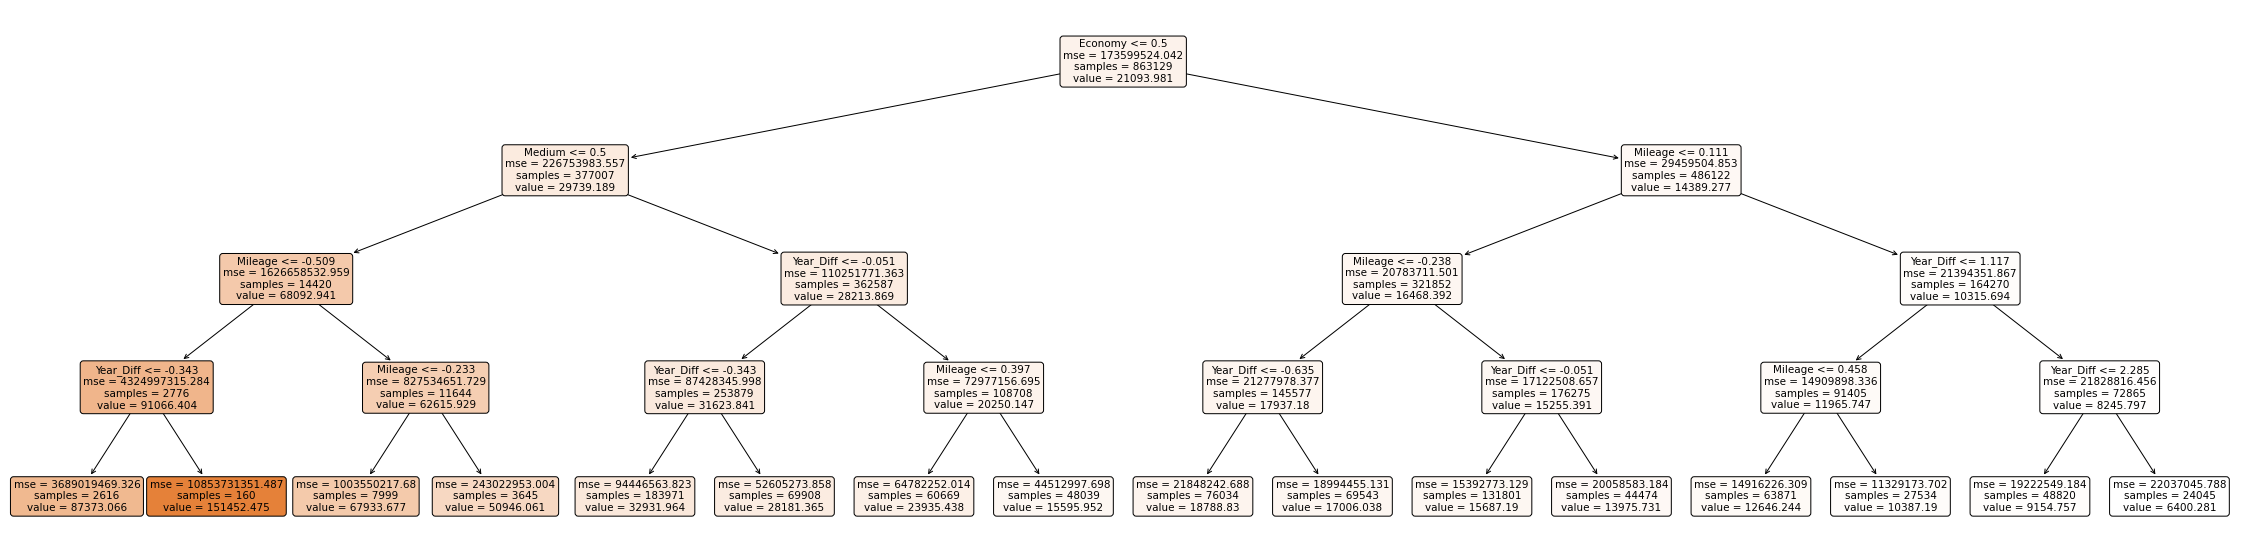

In [81]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
plt.subplots(figsize=(40,10))
plot_tree(DT_reg,
         feature_names=training_preapred_df.columns,
         rounded=True,
         filled=True);

#### H.b.iii) Predicting on Training dataset and Decision Tree RMSE on Training dataset

In [82]:
import numpy as np
from sklearn.metrics import mean_squared_error

usedcar_predictions_DT = DT_reg.predict(training_prepared)
DT_mse = mean_squared_error(Price_label_train, usedcar_predictions_DT)
DT_rmse = np.sqrt(DT_mse)

print("RMSE in TRAINING dataset:", np.round(DT_rmse,1))

RMSE in TRAINING dataset: 8059.0


#### H.b.iv) Calculating Mean Absolute Error in Training dataset for Decision Tree

In [83]:
from sklearn.metrics import mean_absolute_error

DT_mae = mean_absolute_error(Price_label_train, usedcar_predictions_DT)

print("Mean Absolute Error in TRAINING dataset using Decision Tree:",np.round(DT_mae,1))

Mean Absolute Error in TRAINING dataset using Decision Tree: 4741.9


#### H.b.v) Predicting on Test dataset and Decision Tree RMSE on Test dataset

In [84]:
from sklearn.metrics import mean_squared_error

usedcar_predictions_DT_test = DT_reg.predict(test_prepared)
DT_mse_test = mean_squared_error(Price_label_test, usedcar_predictions_DT_test)
DT_rmse_test = np.sqrt(DT_mse_test)

print("RMSE in TEST dataset:", np.round(DT_rmse_test,1))

RMSE in TEST dataset: 8997.3


#### H.b.vi) Calculating Mean Absolute Error in Test dataset for Decision Tree

In [85]:
from sklearn.metrics import mean_absolute_error

DT_mae_test = mean_absolute_error(Price_label_test, usedcar_predictions_DT_test)

print("Mean Absolute Error in TEST dataset using Decision Tree:",np.round(DT_mae_test,1))

Mean Absolute Error in TEST dataset using Decision Tree: 5023.1


#### H.b.vii) R-square in Training and Test dataset using Decision Tree regressor

In [86]:
from sklearn.metrics import r2_score
DT_train_r2=r2_score(Price_label_train,usedcar_predictions_DT)
DT_test_r2=r2_score(Price_label_test,usedcar_predictions_DT_test)

print("Training dataset R-squared value using Decision Tree:",np.round(DT_train_r2*100,2))

print("Test dataset R-squared value using Decision Tree:",np.round(DT_test_r2*100,2))

Training dataset R-squared value using Decision Tree: 62.59
Test dataset R-squared value using Decision Tree: 52.57


#### H.b.viii) Running 5-fold Cross validation using Decision Tree regressor

In [87]:
from sklearn.model_selection import cross_val_score

DT_scores = cross_val_score(DT_reg, training_prepared, Price_label_train,
                         scoring="neg_mean_squared_error", cv=5)
DT_rmse_scores = np.sqrt(-DT_scores)

print("Avg. RMSE in 5-fold CV dataset using Decision Tree:",np.round(DT_rmse_scores.mean(),1))
print("STD DEV RMSE in 5-fold CV dataset using Decision Tree:",np.round(DT_rmse_scores.std(),1))

Avg. RMSE in 5-fold CV dataset using Decision Tree: 8090.6
STD DEV RMSE in 5-fold CV dataset using Decision Tree: 95.3


#### H.b.ix) Training and Test MAPE using Decision Tree

In [98]:
DT_train_mape = mean_absolute_percentage_error(Price_label_train, usedcar_predictions_DT)
DT_test_mape = mean_absolute_percentage_error(Price_label_test, usedcar_predictions_DT_test)

print("Decision Tree Training MAPE%:", np.round(DT_train_mape,2))
print("Decision Tree Test MAPE%:", np.round(DT_test_mape,2))

Decision Tree Training MAPE%: 25.47
Decision Tree Test MAPE%: 26.12


### H.c) Random Forest

#### H.c.i) Determining number of trees

In [116]:
#This is to be done. Not able to run more than 10 trees
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
from sklearn.metrics import mean_absolute_error

train_results = []
test_results = []
list_nb_trees = [4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50]

for nb_trees in list_nb_trees:
    rf = RandomForestRegressor(n_estimators=nb_trees,random_state=30,max_depth=4)
    rf.fit(training_prepared, Price_label_train)

    train_results.append(mean_squared_error(Price_label_train, rf.predict(training_prepared)))
    train_results_lmse=np.sqrt(train_results)
    test_results.append(mean_squared_error(Price_label_test, rf.predict(test_prepared)))
    test_results_lmse=np.sqrt(test_results)

RandomForestRegressor(max_depth=4, n_estimators=4, random_state=30)

RandomForestRegressor(max_depth=4, n_estimators=6, random_state=30)

RandomForestRegressor(max_depth=4, n_estimators=8, random_state=30)

RandomForestRegressor(max_depth=4, n_estimators=10, random_state=30)

RandomForestRegressor(max_depth=4, n_estimators=12, random_state=30)

RandomForestRegressor(max_depth=4, n_estimators=14, random_state=30)

RandomForestRegressor(max_depth=4, n_estimators=16, random_state=30)

RandomForestRegressor(max_depth=4, n_estimators=18, random_state=30)

RandomForestRegressor(max_depth=4, n_estimators=20, random_state=30)

RandomForestRegressor(max_depth=4, n_estimators=22, random_state=30)

RandomForestRegressor(max_depth=4, n_estimators=24, random_state=30)

RandomForestRegressor(max_depth=4, n_estimators=26, random_state=30)

RandomForestRegressor(max_depth=4, n_estimators=28, random_state=30)

RandomForestRegressor(max_depth=4, n_estimators=30, random_state=30)

RandomForestRegressor(max_depth=4, n_estimators=32, random_state=30)

RandomForestRegressor(max_depth=4, n_estimators=34, random_state=30)

RandomForestRegressor(max_depth=4, n_estimators=36, random_state=30)

RandomForestRegressor(max_depth=4, n_estimators=38, random_state=30)

RandomForestRegressor(max_depth=4, n_estimators=40, random_state=30)

RandomForestRegressor(max_depth=4, n_estimators=42, random_state=30)

RandomForestRegressor(max_depth=4, n_estimators=44, random_state=30)

RandomForestRegressor(max_depth=4, n_estimators=46, random_state=30)

RandomForestRegressor(max_depth=4, n_estimators=48, random_state=30)

RandomForestRegressor(max_depth=4, n_estimators=50, random_state=30)

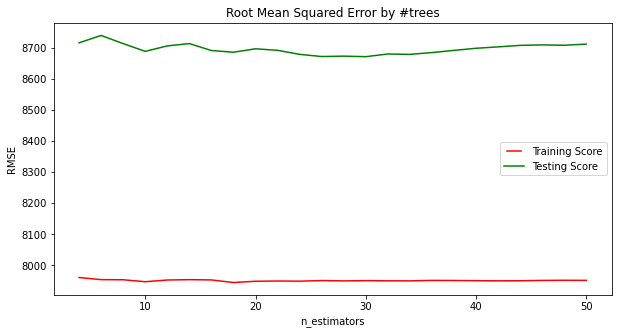

In [139]:
plt.figure(figsize=(10,5));

line1, = plt.plot(list_nb_trees, train_results_lmse, color="r", label="Training Score")
line2, = plt.plot(list_nb_trees, test_results_lmse, color="g", label="Testing Score")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.title('Root Mean Squared Error by #trees')
plt.ylabel('RMSE')
plt.xlabel('n_estimators')
plt.show();

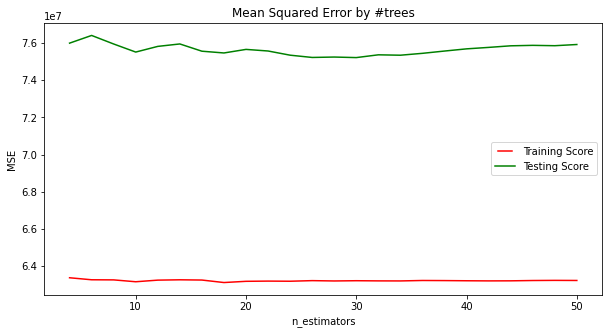

In [138]:
plt.figure(figsize=(10,5));

line1, = plt.plot(list_nb_trees, train_results, color="r", label="Training Score")
line2, = plt.plot(list_nb_trees, test_results, color="g", label="Testing Score")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.title('Mean Squared Error by #trees')
plt.ylabel('MSE')
plt.xlabel('n_estimators')
plt.show();

In [152]:
#Creating dataframe with Training RMSEs
RF_train_rmse=pd.DataFrame(np.round(train_results_lmse,2))
RF_train_rmse.columns=["Train_RMSE"]

#Creating dataframe with Test RMSEs
RF_test_rmse=pd.DataFrame(np.round(test_results_lmse,2))
RF_test_rmse.columns=["Test_RMSE"]

#Creating dataframe with Number of Trees
Trees=pd.DataFrame(list_nb_trees)
Trees.columns=["N_trees"]

Train_test_rmse=pd.concat([Trees,RF_train_rmse,RF_test_rmse],axis=1)
Train_test_rmse

#Train_test_lmse['N_Trees']=Train_test_lmse.apply(lambda x:4, axis=1)
#Train_test_lmse

,N_trees,Train_RMSE,Test_RMSE
0,4,7961.06,8717.32
1,6,7954.27,8741.02
2,8,7953.86,8714.70
3,10,7947.59,8689.77
4,12,7953.03,8707.31
5,14,7954.19,8714.83
6,16,7953.34,8692.45
7,18,7944.91,8686.98
8,20,7949.05,8698.02
9,22,7949.79,8693.06


#### Result: 30 as number of Trees has lowest RMSE value for Test dataset (8672.66) and RMSE for Training dataset is not the lowest but comparable to RMSE obtained for other values of N_trees (7951.08). Will go ahead with 30 as number of trees in Random forest model

#### H.c.ii) Fitting a Random Forest model

In [100]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=30, random_state=30,oob_score = True,max_depth=4)
forest_reg.fit(training_prepared, Price_label_train)

/opt/conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:832: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


RandomForestRegressor(max_depth=4, n_estimators=30, oob_score=True,
                      random_state=30)

`#### H.c.iii) Predicting on Training dataset and RMSE for Training dataset

In [101]:
from sklearn.metrics import mean_squared_error

usedcar_predictions_Forest = forest_reg.predict(training_prepared)
forest_mse = mean_squared_error(Price_label_train, usedcar_predictions_Forest)
forest_rmse = np.sqrt(forest_mse)
print("RANDOM FOREST TRAINING RMSE:",np.round(forest_rmse, 2))

RANDOM FOREST TRAINING RMSE: 7972.79


#### H.c.iv) Calculating Mean Absolute Error for Training dataset

In [102]:
from sklearn.metrics import mean_absolute_error

Forest_mae = mean_absolute_error(Price_label_train, usedcar_predictions_Forest)

print("Mean Absolute Error in TRAINING dataset using Random Forest:",np.round(Forest_mae,1))

Mean Absolute Error in TRAINING dataset using Random Forest: 4688.9


#### H.c.v) Calculating score and OOB error rate in Training dataset

In [103]:
print('Training dataset Score:', forest_reg.score(training_prepared, Price_label_train))
print('OOB Score:', forest_reg.oob_score_)

Training dataset Score: 0.6338386284461519
OOB Score: 0.6315255662651444


#### H.c.vi) Predicting on Test dataset and RMSE for Test dataset

In [105]:
usedcar_predictions_Forest_test = forest_reg.predict(test_prepared)
forest_mse_test = mean_squared_error(Price_label_test, usedcar_predictions_Forest_test)
forest_rmse_test = np.sqrt(forest_mse_test)
print("RANDOM FOREST TEST RMSE:",np.round(forest_rmse_test, 1))

RANDOM FOREST TEST RMSE: 8597.5


#### H.c.vii) Calculating Root Mean Square Error for Test Dataset

In [106]:
from sklearn.metrics import mean_absolute_error

Forest_mae_test = mean_absolute_error(Price_label_test, usedcar_predictions_Forest_test)

print("Mean Absolute Error in TEST dataset using Random Forest:",np.round(Forest_mae_test,1))

Mean Absolute Error in TEST dataset using Random Forest: 4969.6


#### H.c.viii) R-square for Training & Test dataset using Random Forest regressor

In [107]:
from sklearn.metrics import r2_score
RF_train_r2=r2_score(Price_label_train,usedcar_predictions_Forest)
RF_test_r2=r2_score(Price_label_test,usedcar_predictions_Forest_test)

print("Training dataset R-squared value using Random Forest:",np.round(RF_train_r2*100,2))

print("Test dataset R-squared value using Random Forest",np.round(RF_test_r2*100,2))

Training dataset R-squared value using Random Forest: 63.38
Test dataset R-squared value using Random Forest 56.69


#### H.c.ix) Running 5-fold Cross validation using Random Forest regressor

In [108]:
from sklearn.model_selection import cross_val_score

forest_reg_wo_OOB = RandomForestRegressor(n_estimators=20, random_state=30,max_depth=4)

forest_score = cross_val_score(forest_reg_wo_OOB, training_prepared, Price_label_train,
                                scoring="neg_mean_squared_error", cv=5)
forest_rmse_score = np.sqrt(-forest_score)

print("Random Forest Avg. RMSE in 5-fold CV dataset:",np.round(forest_rmse_score.mean(),1))
print("Random Forest STD DEV RMSE in 5-fold CV dataset:",np.round(forest_rmse_score.std(),1))

Random Forest Avg. RMSE in 5-fold CV dataset: 7984.4
Random Forest STD DEV RMSE in 5-fold CV dataset: 97.4


#### H.c.x) Determining feature importance from Random forest regressor

In [109]:
feature_importances=forest_reg.feature_importances_
feature_importances

array([0.1002148 , 0.13158101, 0.        , 0.5334023 , 0.07838601,
       0.15641588])

In [110]:
one_hot_variables = list(cat_encoder.categories_[0])

Features = num_variables + one_hot_variables

Features

Feature_imp_DF=pd.DataFrame(zip(Features,feature_importances),columns=['Feature_name','Feature_imp'])
Feature_imp_DF.sort_values(by=['Feature_imp'],ascending=False)

['Mileage', 'Year_Diff', 'M_Income_2018', 'Economy', 'Medium', 'Premium']

,Feature_name,Feature_imp
3,Economy,0.533402
5,Premium,0.156416
1,Year_Diff,0.131581
0,Mileage,0.100215
4,Medium,0.078386
2,M_Income_2018,0.000000


#### H.c.xi) MAPE for Training & Test datasets

In [111]:
RF_train_mape = mean_absolute_percentage_error(Price_label_train, usedcar_predictions_Forest)
RF_test_mape = mean_absolute_percentage_error(Price_label_test, usedcar_predictions_Forest_test)

print("Random Forest Training MAPE:", np.round(line_reg_train_mape,2))
print("Random Forest Test MAPE:", np.round(line_reg_test_mape,2))

Random Forest Training MAPE: 27.02
Random Forest Test MAPE: 26.99


## (Part I): Execute Random Forest using Spark ML and perform Grid search

In [112]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

### I.a) Creating a numercal dataframe keeping numerical columns only

In [113]:
usedcar_data_df_v2=usedcar_data_df.drop(['Id'],axis=1)

usedcar_data_df_v2_num=usedcar_data_df_v2.drop(['Model_Category'],axis=1)

### I.b) Running pipeline on full dataset

In [115]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline2 = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

usedcar_num_train2 = num_pipeline2.fit_transform(usedcar_data_df_v2_num)

In [116]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

num_variables2 = ['Mileage','Year_Diff','M_Income_2018']
cat_variables2 = ["Model_Category"]

full_pipeline2 = ColumnTransformer([
        ("num", num_pipeline2, num_variables2),
        ("cat", OneHotEncoder(), cat_variables2),
    ])

full_prepared2 = full_pipeline2.fit_transform(usedcar_data_df_v2)

### I.c) Creating a full dataset where features are standardized but lable variable (Price) isn't standardized

In [117]:
import pandas as pd
fulldata_preapred_df2=pd.DataFrame(full_prepared2, columns=['Mileage','Year_Diff','M_Income_2018','Economy','Medium','Premium'])
fulldata_preapred_df2["Price"]=usedcar_data_df_v2.Price
fulldata_preapred_df2.head(5)

,Mileage,Year_Diff,M_Income_2018,Economy,Medium,Premium,Price
0,-0.219203,-0.197125,0.652530,0.0,1.0,0.0,23950
1,-0.229223,-0.197125,-1.037232,0.0,1.0,0.0,21990
2,0.440625,0.094956,0.652530,0.0,1.0,0.0,18888
3,0.194981,-0.197125,-0.911713,0.0,1.0,0.0,21250
4,-0.175929,-0.489205,0.652530,0.0,1.0,0.0,25950


### I.d) Pipeline step for running Random Forest using PySpark ML. have to use Vector Assembler

In [118]:
from pyspark.ml.feature import StringIndexer, VectorAssembler

categoricalColumns = ['Economy','Medium',"Premium"]
stages = []
#for categoricalCol in categoricalColumns:
#    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
#    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
#    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'Price', outputCol = 'label')
stages += [label_stringIdx]

numericCols = ['Mileage', 'Year_Diff', 'M_Income_2018']

assemblerInputs = categoricalColumns + numericCols

assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

### I.e) Converting the pandas DataFrame to Spark DataFrame to be used later for running Spark ML Random Forest

In [119]:
fulldata_preapred_pyspdf = sqlContext.createDataFrame(fulldata_preapred_df2)

In [120]:
fulldata_preapred_pyspdf.show(5)

+-------------------+--------------------+-------------------+-------+------+-------+-----+
|            Mileage|           Year_Diff|      M_Income_2018|Economy|Medium|Premium|Price|
+-------------------+--------------------+-------------------+-------+------+-------+-----+
|-0.2192029376869179|-0.19712476210024932|  0.652529919296431|    0.0|   1.0|    0.0|23950|
|-0.2292232211358643|-0.19712476210024932| -1.037231911823049|    0.0|   1.0|    0.0|21990|
| 0.4406253595707239| 0.09495556065436911|  0.652529919296431|    0.0|   1.0|    0.0|18888|
| 0.1949810579619943|-0.19712476210024932|-0.9117128411239246|    0.0|   1.0|    0.0|21250|
|-0.1759290665176936|-0.48920508485486774|  0.652529919296431|    0.0|   1.0|    0.0|25950|
+-------------------+--------------------+-------------------+-------+------+-------+-----+
only showing top 5 rows



### I.f) Pipeline on Spark DataFrame which will create columns features and label, which are required to run Spark ML Random Forest

In [121]:
cols=fulldata_preapred_pyspdf.columns

from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(fulldata_preapred_pyspdf)
df = pipelineModel.transform(fulldata_preapred_pyspdf)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- Mileage: double (nullable = true)
 |-- Year_Diff: double (nullable = true)
 |-- M_Income_2018: double (nullable = true)
 |-- Economy: double (nullable = true)
 |-- Medium: double (nullable = true)
 |-- Premium: double (nullable = true)
 |-- Price: long (nullable = true)



In [50]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
label,435,160,291,993,550
features,"[0.0, 1.0, 0.0, -0.2192029376869179, -0.197124...","[0.0, 1.0, 0.0, -0.2292232211358643, -0.197124...","[0.0, 1.0, 0.0, 0.4406253595707239, 0.09495556...","[0.0, 1.0, 0.0, 0.1949810579619943, -0.1971247...","[0.0, 1.0, 0.0, -0.1759290665176936, -0.489205..."
Mileage,-0.219203,-0.229223,0.440625,0.194981,-0.175929
Year_Diff,-0.197125,-0.197125,0.0949556,-0.197125,-0.489205
M_Income_2018,0.65253,-1.03723,0.65253,-0.911713,0.65253
Economy,0,0,0,0,0
Medium,1,1,1,1,1
Premium,0,0,0,0,0
Price,23950,21990,18888,21250,25950


### I.g) Creating Training and Test dataset using Random split of 70-30

In [122]:
train, test = df.randomSplit([0.7, 0.3], seed = 30)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 863530
Test Dataset Count: 369512


### I.h) Run Random forest regressor model

In [123]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol = 'features', labelCol = 'label')

In [ ]:
#rfModel = rf.fit(train)
#predictions = rfModel.transform(test)

#predictions.select("prediction", "label", "features").show(5)

In [ ]:
#from pyspark.ml.evaluation import RegressionEvaluator
#evaluator = RegressionEvaluator(
#    labelCol="label", predictionCol="prediction", metricName="rmse")
#rmse = evaluator.evaluate(predictions)
#print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

## I.i) Pipeline for Grid search and using Random Forest regressor for Grid Search algorithm/

In [124]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[rf])

In [125]:
from pyspark.ml.tuning import ParamGridBuilder
import numpy as np

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 30, num = 5)]) \
    .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 1, stop = 4, num = 2)]) \
    .build()

### I.j) Forest Regressor on 3-fold Cross-validated dataset

In [126]:
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=3)

### I.k) Fit the cross-validated regressor to train dataset

In [127]:
cvModel = crossval.fit(train)

### I.l) Predicting on Test dataset

In [128]:
predictions = cvModel.transform(test)

In [140]:
type(predictions)

pyspark.sql.dataframe.DataFrame

### I.m) Feature importance

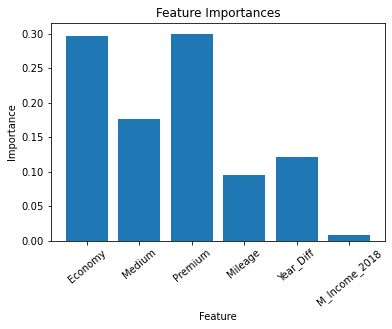

In [129]:
bestPipeline = cvModel.bestModel
bestModel = bestPipeline.stages[0]

importances = bestModel.featureImportances

x_values = list(range(len(importances)))

plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, assemblerInputs, rotation=40)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances');

### I.n) Best model hyperparameter values

In [130]:
print('Number of Trees for Best model from Grid Search:', bestModel.getNumTrees)
print('Max Depth for Best model from Grid Search - ', bestModel.getOrDefault('maxDepth'))

Number of Trees for Best model from Grid Search: 25
Max Depth for Best model from Grid Search -  4


### I.o) Getting RMSE value for the prediction on Test dataset

In [131]:
#import matplotlib.pyplot as plt

evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

test_rmse = evaluator.evaluate(predictions)

print("Root Mean Squared Error (RMSE) on TEST data = %g" % test_rmse)

Root Mean Squared Error (RMSE) on TEST data = 7936.25


## (Part J): Comparison between the different models and Conclusion

### J.a) Creating a blank dataframe which will be used to comapred model performance statistic between different regressors

In [133]:
comparison_table = pd.DataFrame(columns = ['Lin_Regression', 'Decision_Tree', 'Random_Forest','Random_Forest_GridSearch'],  
                   index = ['Training_RMSE', 'Test_RMSE', 'CV_RMSE','Training_R_sqr%','Test_R_sqr%','Training_Accuracy%','Test_Accuracy%'])
comparison_table

,Lin_Regression,Decision_Tree,Random_Forest,Random_Forest_GridSearch
Training_RMSE,NaN,NaN,NaN,NaN
Test_RMSE,NaN,NaN,NaN,NaN
CV_RMSE,NaN,NaN,NaN,NaN
Training_R_sqr%,NaN,NaN,NaN,NaN
Test_R_sqr%,NaN,NaN,NaN,NaN
Training_Accuracy%,NaN,NaN,NaN,NaN
Test_Accuracy%,NaN,NaN,NaN,NaN


### J.b) Filling the dataframe with relevant values

In [137]:
#For Linear regression column values
comparison_table.at['Training_RMSE','Lin_Regression']=lin_rmse
comparison_table.at['Test_RMSE','Lin_Regression']=lin_rmse_test
comparison_table.at['CV_RMSE','Lin_Regression']=lin_rmse_scores.mean()
comparison_table.at['Training_R_sqr%','Lin_Regression']=np.round(lin_train_r2*100,2)
comparison_table.at['Test_R_sqr%','Lin_Regression']=np.round(lin_test_r2*100,2)
comparison_table.at['Training_Accuracy%','Lin_Regression']=np.round(100-line_reg_train_mape,2)
comparison_table.at['Test_Accuracy%','Lin_Regression']=np.round(100-line_reg_test_mape ,2)

#For Decision Tree column values
comparison_table.at['Training_RMSE','Decision_Tree']=DT_rmse
comparison_table.at['Test_RMSE','Decision_Tree']=DT_rmse_test
comparison_table.at['CV_RMSE','Decision_Tree']=lin_rmse_scores.mean()
comparison_table.at['Training_R_sqr%','Decision_Tree']=np.round(DT_train_r2*100,2)
comparison_table.at['Test_R_sqr%','Decision_Tree']=np.round(DT_test_r2*100,2)
comparison_table.at['Training_Accuracy%','Decision_Tree']=np.round(100-DT_train_mape,2)
comparison_table.at['Test_Accuracy%','Decision_Tree']=np.round(100-DT_test_mape ,2)


#For Random Forest column values
comparison_table.at['Training_RMSE','Random_Forest']=forest_rmse
comparison_table.at['Test_RMSE','Random_Forest']=forest_rmse_test
comparison_table.at['CV_RMSE','Random_Forest']=forest_rmse_score.mean()
comparison_table.at['Training_R_sqr%','Random_Forest']=np.round(RF_train_r2*100,2)
comparison_table.at['Test_R_sqr%','Random_Forest']=np.round(RF_test_r2*100,2)
comparison_table.at['Training_Accuracy%','Random_Forest']=np.round(100-RF_train_mape,2)
comparison_table.at['Test_Accuracy%','Random_Forest']=np.round(100-RF_test_mape ,2)


#For Random Forest thru Grid Search output column values
comparison_table.at['Test_RMSE','Random_Forest_GridSearch']=test_rmse

comparison_table

,Lin_Regression,Decision_Tree,Random_Forest,Random_Forest_GridSearch
Training_RMSE,8488.79,8058.99,7972.79,NaN
Test_RMSE,8347.47,8997.29,8597.47,7936.25
CV_RMSE,9831.28,9831.28,7984.41,NaN
Training_R_sqr%,58.49,62.59,63.38,NaN
Test_R_sqr%,59.17,52.57,56.69,NaN
Training_Accuracy%,72.98,74.53,74.74,NaN
Test_Accuracy%,73.01,73.88,73.87,NaN


#### Note: 
* Accuracy in above table is (100 - MAPE)
* Training & Test datasets are same for Linear regression, Decision Tree & Random Forest (using Stratified random sample method and 70-30 percentage splits). But Training & Test datasets used for Spark ML Random Forest (result of Grid Search) is different, it's done through Random Sample method (using 70-30 percentage split)

### J.c) Conclusion:
* In terms of model accuracy, RMSE and R-square values, all the 3 models perform similarly with Random Forest doing slightly better than others in terms of slightly lower RMSEs and slightly higher R-square & Accuracy (100-MAPE) values
* The good thing is RMSE is quite consistent between Training and Test datasets indicating the model performance doesn't degrade with Test dataset
* Random forest output from Grid search produces best RMSE in Test dataset compared to other models. However, couldn't find resources to calculate R-square or Accuracy using Spark ML method
* Most important features are: Economy model, Premium model, Number of years difference between latest year (2020) and Car model, Mileage of the car
* However, we need more variables to be able to improve R-square & Accuracy of the prediction models. We tried to overcome the challenge by (a) bringing in data from external source (State wise median income from US Labor force) as part of feature engineering, (b) use of interaction variables between predictors, (c) use of squared variables of predictors. But it didn't improve results of models